In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

import sys
sys.path.append('../')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [3]:
### choose if you want to do only the 45 validation glaciers
validation_only = 0

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

# select which rgis to analyze
if validation_only:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# get list of rgis to analyze
rgis_to_analyze = list(set( [ i[3:17] for i in os.listdir(os.path.join(folder_save, "Average AAs")) if i[-3:]=='tif' ] ))

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))
# print(rgis_to_analyze[:10])
# print(rgis_to_analyze_df[:10])

3002


In [4]:
# open the list of the final ELA calculated for each average product
path_all_ela = os.path.join(folder_save, 'Average AAs', 'final_glacier_stats.csv')
df_all_ela = pd.read_csv(path_all_ela)#.sort_values('total_area')
df_all_ela

,RGIId,ela,aar,off_glacier,total_area,total_observed,total_snow,total_snow_infill,aar_infill
0,RGI60-01.20889,1400,0.6835,0,2.0445,1.1689,0.7990,1.1567,0.565762
1,RGI60-01.11632,1710,0.0411,1,2.0436,1.8608,0.0764,0.0764,0.037385
2,RGI60-01.08203,1170,0.2218,1,2.0598,1.9057,0.4226,0.4226,0.205166
3,RGI60-01.25183,2440,0.2939,0,2.0824,1.8965,0.5574,0.7133,0.342537
4,RGI60-01.11595,1430,0.2666,0,2.0488,1.3949,0.3719,0.7546,0.368313
...,...,...,...,...,...,...,...,...,...
2997,RGI60-01.16201,2000,0.5523,0,1062.3297,961.2816,530.9023,628.2290,0.591369
2998,RGI60-01.17566,2130,0.4140,0,1187.7931,1017.7733,421.3875,585.1992,0.492678
2999,RGI60-01.14443,1080,0.8544,0,2854.2166,2528.4904,2160.4047,2475.3661,0.867266
3000,RGI60-01.13635,1400,0.4722,0,3040.1670,2849.1098,1345.4882,1516.2110,0.498726


In [76]:
# for each glacier, open the average product, infill missing data, resave
i=0
for idx,row in df_all_ela.iterrows():
    i+=1
#     if i>10: break
        
    # get rgiid
    rgiid = row['RGIId']
    
#     if rgiid!="RGI60-01.13696": continue
#     row_save = row.copy() 
    
    # grab just this rgi geometry and info
    rgi_single = rgi_gdf[rgi_gdf['RGIId']==rgiid].to_crs("EPSG:3338")
    single_geometry = rgi_single.geometry
    ga = rgi_single['Area'].values[0]
    
    print(f"Starting {i} of {len(df_all_ela)}: {rgiid}  {ga} km2")
    
    # open list of annual ELAs for this glacier
    annual_elas = pd.read_csv(os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv"))
    
    # make copy
    df_annual = annual_elas.copy()
    
    # add year column
    df_annual['year']=[d[:4] for d in df_annual['date']]
    
    # add new row with average product info
    add_row = pd.DataFrame({'ela':row['ela'], 'year':9, 'off_glacier':row['off_glacier']}, index=[5])
    df_annual = pd.concat([df_annual,add_row], axis=0, ignore_index=True)

    ### go through each year, and then the final product
    for idx2,row in df_annual.iterrows():
    
        # grab year
        y = row['year']
        
        # get the average product's ela that was found
        ela = row['ela']
        
        # if ela is -9999, continue (means there is no product for this year)
        if ela==-9999: continue

        # correction for when ela is off glacier (set it really high)
        if row['off_glacier'] in [1,'1','True']:
            ela=9999
        
        # define path to open
        if row['year']==9:
            path_open = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA_final.tif")
        else:
            path_open = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_{y}_AA_final.tif")

        # open glacier products
#         path_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA_final.tif")
        snow = riox.open_rasterio(path_open)
        
        # open dem
        if row['year']==9:
            xr_dem = snowFun.get_year_DEM(single_geometry, 2020, smoothed=0) 
        else:
            xr_dem = snowFun.get_year_DEM(single_geometry, int(y), smoothed=0)                          
#         xr_dem = snowFun.get_year_DEM(single_geometry, 2020, smoothed=0) 

        # make sure dimensions match up
        xr_dem = xr_dem.reindex_like(snow, method='nearest')

        # infill by making pixels at or above ela snow, below ela ice
        snow_infill = xr.where(xr_dem<ela, 1, 2)
        snow_infill = snow.where(snow<3, snow_infill).squeeze()

        # calculate the snow cover / aar after infilling
        snow_post = xr.where(snow_infill==2,1,0).sum().values
        snow_post = float(snow_post)*(10*10)/(1000*1000)

        obs_post = xr.where(snow_infill>0,1,0).sum().values
        obs_post = float(obs_post)*(10*10)/(1000*1000)

        aar_post = snow_post/obs_post
                                     
        # save infilled data to csvs
        if row['year']==9:
            df_all_ela.loc[idx, 'total_snow_infill'] = snow_post
            df_all_ela.loc[idx, 'aar_infill'] = round(aar_post,4)
        else:                    
            annual_elas.loc[idx2, 'total_snow_infill'] = snow_post
            annual_elas.loc[idx2, 'aar_infill'] = round(aar_post,4)

        # save infilled tifs
        if row['year']==9:
            out_path = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA_final_infill.tif")
        else:                    
            out_path = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_{y}_AA_final_infill.tif")
        snow_infill.rio.to_raster(raster_path=out_path, compress='DEFLATE')
    
    # resave the annual csv
    annual_elas.to_csv(os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv"), index=False)

# resave the final average glacier stats info (with infilled aar)
df_all_ela.to_csv(path_all_ela, index=False)

print('Done!')
    

Starting 1 of 3002: RGI60-01.20889  2.0 km2
Starting 2 of 3002: RGI60-01.11632  2.0 km2
Starting 3 of 3002: RGI60-01.08203  2.002 km2
Starting 4 of 3002: RGI60-01.25183  2.002 km2
Starting 5 of 3002: RGI60-01.11595  2.003 km2
Starting 6 of 3002: RGI60-01.03614  2.004 km2
Starting 7 of 3002: RGI60-01.05487  2.004 km2
Starting 8 of 3002: RGI60-01.09047  2.004 km2
Starting 9 of 3002: RGI60-01.03088  2.005 km2
Starting 10 of 3002: RGI60-01.17509  2.005 km2
Starting 11 of 3002: RGI60-01.10867  2.005 km2
Starting 12 of 3002: RGI60-01.02453  2.006 km2
Starting 13 of 3002: RGI60-01.12977  2.006 km2
Starting 14 of 3002: RGI60-01.08199  2.006 km2
Starting 15 of 3002: RGI60-01.19457  2.007 km2
Starting 16 of 3002: RGI60-01.05254  2.009 km2
Starting 17 of 3002: RGI60-01.02906  2.01 km2
Starting 18 of 3002: RGI60-01.19826  2.012 km2
Starting 19 of 3002: RGI60-01.00315  2.014 km2
Starting 20 of 3002: RGI60-01.00564  2.015 km2
Starting 21 of 3002: RGI60-01.02527  2.016 km2
Starting 22 of 3002: RGI60-

Starting 175 of 3002: RGI60-01.02945  2.13 km2
Starting 176 of 3002: RGI60-01.00077  2.13 km2
Starting 177 of 3002: RGI60-01.13830  2.13 km2
Starting 178 of 3002: RGI60-01.00559  2.13 km2
Starting 179 of 3002: RGI60-01.03179  2.132 km2
Starting 180 of 3002: RGI60-01.20866  2.133 km2
Starting 181 of 3002: RGI60-01.10856  2.133 km2
Starting 182 of 3002: RGI60-01.00670  2.134 km2
Starting 183 of 3002: RGI60-01.05455  2.135 km2
Starting 184 of 3002: RGI60-01.09107  2.137 km2
Starting 185 of 3002: RGI60-01.01671  2.138 km2
Starting 186 of 3002: RGI60-01.01786  2.138 km2
Starting 187 of 3002: RGI60-01.06230  2.138 km2
Starting 188 of 3002: RGI60-01.24747  2.139 km2
Starting 189 of 3002: RGI60-01.22792  2.139 km2
Starting 190 of 3002: RGI60-01.23682  2.139 km2
Starting 191 of 3002: RGI60-01.07055  2.14 km2
Starting 192 of 3002: RGI60-01.23254  2.14 km2
Starting 193 of 3002: RGI60-01.04994  2.141 km2
Starting 194 of 3002: RGI60-01.23669  2.142 km2
Starting 195 of 3002: RGI60-01.18960  2.143 km

Starting 347 of 3002: RGI60-01.13177  2.274 km2
Starting 348 of 3002: RGI60-01.01278  2.275 km2
Starting 349 of 3002: RGI60-01.21276  2.275 km2
Starting 350 of 3002: RGI60-01.20198  2.275 km2
Starting 351 of 3002: RGI60-01.07046  2.276 km2
Starting 352 of 3002: RGI60-01.15491  2.277 km2
Starting 353 of 3002: RGI60-01.19385  2.278 km2
Starting 354 of 3002: RGI60-01.20508  2.278 km2
Starting 355 of 3002: RGI60-01.03688  2.278 km2
Starting 356 of 3002: RGI60-01.04161  2.278 km2
Starting 357 of 3002: RGI60-01.05049  2.279 km2
Starting 358 of 3002: RGI60-01.15254  2.279 km2
Starting 359 of 3002: RGI60-01.13917  2.28 km2
Starting 360 of 3002: RGI60-01.16288  2.281 km2
Starting 361 of 3002: RGI60-01.16834  2.281 km2
Starting 362 of 3002: RGI60-01.08681  2.282 km2
Starting 363 of 3002: RGI60-01.01721  2.284 km2
Starting 364 of 3002: RGI60-01.08080  2.284 km2
Starting 365 of 3002: RGI60-01.01331  2.285 km2
Starting 366 of 3002: RGI60-01.19568  2.286 km2
Starting 367 of 3002: RGI60-01.20974  2.2

Starting 519 of 3002: RGI60-01.08064  2.431 km2
Starting 520 of 3002: RGI60-01.03145  2.433 km2
Starting 521 of 3002: RGI60-01.19053  2.436 km2
Starting 522 of 3002: RGI60-01.18932  2.436 km2
Starting 523 of 3002: RGI60-01.20799  2.436 km2
Starting 524 of 3002: RGI60-01.11882  2.439 km2
Starting 525 of 3002: RGI60-01.06210  2.439 km2
Starting 526 of 3002: RGI60-01.15763  2.44 km2
Starting 527 of 3002: RGI60-01.12424  2.44 km2
Starting 528 of 3002: RGI60-01.25200  2.443 km2
Starting 529 of 3002: RGI60-01.01276  2.444 km2
Starting 530 of 3002: RGI60-01.06816  2.446 km2
Starting 531 of 3002: RGI60-01.19656  2.449 km2
Starting 532 of 3002: RGI60-01.12083  2.45 km2
Starting 533 of 3002: RGI60-01.09450  2.451 km2
Starting 534 of 3002: RGI60-01.05250  2.451 km2
Starting 535 of 3002: RGI60-01.03385  2.453 km2
Starting 536 of 3002: RGI60-01.19655  2.454 km2
Starting 537 of 3002: RGI60-01.26463  2.455 km2
Starting 538 of 3002: RGI60-01.08643  2.455 km2
Starting 539 of 3002: RGI60-01.03194  2.46 

Starting 691 of 3002: RGI60-01.01606  2.629 km2
Starting 692 of 3002: RGI60-01.26315  2.63 km2
Starting 693 of 3002: RGI60-01.08200  2.633 km2
Starting 694 of 3002: RGI60-01.13841  2.633 km2
Starting 695 of 3002: RGI60-01.08410  2.634 km2
Starting 696 of 3002: RGI60-01.08374  2.635 km2
Starting 697 of 3002: RGI60-01.03784  2.636 km2
Starting 698 of 3002: RGI60-01.04055  2.638 km2
Starting 699 of 3002: RGI60-01.03848  2.641 km2
Starting 700 of 3002: RGI60-01.06113  2.644 km2
Starting 701 of 3002: RGI60-01.10925  2.647 km2
Starting 702 of 3002: RGI60-01.20853  2.649 km2
Starting 703 of 3002: RGI60-01.01773  2.65 km2
Starting 704 of 3002: RGI60-01.00901  2.654 km2
Starting 705 of 3002: RGI60-01.08062  2.655 km2
Starting 706 of 3002: RGI60-01.03384  2.656 km2
Starting 707 of 3002: RGI60-01.17905  2.656 km2
Starting 708 of 3002: RGI60-01.08076  2.656 km2
Starting 709 of 3002: RGI60-01.23757  2.656 km2
Starting 710 of 3002: RGI60-01.12281  2.657 km2
Starting 711 of 3002: RGI60-01.01140  2.65

Starting 862 of 3002: RGI60-01.22147  2.857 km2
Starting 863 of 3002: RGI60-01.14574  2.859 km2
Starting 864 of 3002: RGI60-01.10938  2.859 km2
Starting 865 of 3002: RGI60-01.19803  2.862 km2
Starting 866 of 3002: RGI60-01.20187  2.863 km2
Starting 867 of 3002: RGI60-01.16328  2.863 km2
Starting 868 of 3002: RGI60-01.03102  2.864 km2
Starting 869 of 3002: RGI60-01.14004  2.864 km2
Starting 870 of 3002: RGI60-01.26953  2.866 km2
Starting 871 of 3002: RGI60-01.07256  2.867 km2
Starting 872 of 3002: RGI60-01.22810  2.868 km2
Starting 873 of 3002: RGI60-01.20551  2.869 km2
Starting 874 of 3002: RGI60-01.16308  2.871 km2
Starting 875 of 3002: RGI60-01.04371  2.871 km2
Starting 876 of 3002: RGI60-01.03789  2.872 km2
Starting 877 of 3002: RGI60-01.14626  2.876 km2
Starting 878 of 3002: RGI60-01.14015  2.878 km2
Starting 879 of 3002: RGI60-01.17321  2.88 km2
Starting 880 of 3002: RGI60-01.23473  2.881 km2
Starting 881 of 3002: RGI60-01.17861  2.882 km2
Starting 882 of 3002: RGI60-01.09392  2.8

Starting 1033 of 3002: RGI60-01.02616  3.134 km2
Starting 1034 of 3002: RGI60-01.19449  3.136 km2
Starting 1035 of 3002: RGI60-01.22926  3.138 km2
Starting 1036 of 3002: RGI60-01.13074  3.139 km2
Starting 1037 of 3002: RGI60-01.06753  3.14 km2
Starting 1038 of 3002: RGI60-01.22491  3.148 km2
Starting 1039 of 3002: RGI60-01.14552  3.151 km2
Starting 1040 of 3002: RGI60-01.20192  3.151 km2
Starting 1041 of 3002: RGI60-01.11561  3.158 km2
Starting 1042 of 3002: RGI60-01.18135  3.158 km2
Starting 1043 of 3002: RGI60-01.08113  3.159 km2
Starting 1044 of 3002: RGI60-01.22052  3.16 km2
Starting 1045 of 3002: RGI60-01.14165  3.163 km2
Starting 1046 of 3002: RGI60-01.20316  3.164 km2
Starting 1047 of 3002: RGI60-01.19021  3.169 km2
Starting 1048 of 3002: RGI60-01.22930  3.17 km2
Starting 1049 of 3002: RGI60-01.16327  3.171 km2
Starting 1050 of 3002: RGI60-01.12753  3.173 km2
Starting 1051 of 3002: RGI60-01.08646  3.174 km2
Starting 1052 of 3002: RGI60-01.18433  3.174 km2
Starting 1053 of 3002: 

Starting 1201 of 3002: RGI60-01.00436  3.467 km2
Starting 1202 of 3002: RGI60-01.21767  3.468 km2
Starting 1203 of 3002: RGI60-01.07196  3.468 km2
Starting 1204 of 3002: RGI60-01.11766  3.472 km2
Starting 1205 of 3002: RGI60-01.14056  3.475 km2
Starting 1206 of 3002: RGI60-01.17996  3.476 km2
Starting 1207 of 3002: RGI60-01.09680  3.478 km2
Starting 1208 of 3002: RGI60-01.20754  3.485 km2
Starting 1209 of 3002: RGI60-01.16511  3.485 km2
Starting 1210 of 3002: RGI60-01.19641  3.486 km2
Starting 1211 of 3002: RGI60-01.03991  3.489 km2
Starting 1212 of 3002: RGI60-01.21459  3.489 km2
Starting 1213 of 3002: RGI60-01.23973  3.49 km2
Starting 1214 of 3002: RGI60-01.21755  3.491 km2
Starting 1215 of 3002: RGI60-01.21715  3.498 km2
Starting 1216 of 3002: RGI60-01.02975  3.499 km2
Starting 1217 of 3002: RGI60-01.05869  3.499 km2
Starting 1218 of 3002: RGI60-01.23932  3.501 km2
Starting 1219 of 3002: RGI60-01.15181  3.505 km2
Starting 1220 of 3002: RGI60-01.22577  3.506 km2
Starting 1221 of 3002

Starting 1369 of 3002: RGI60-01.19703  3.835 km2
Starting 1370 of 3002: RGI60-01.16669  3.844 km2
Starting 1371 of 3002: RGI60-01.16035  3.845 km2
Starting 1372 of 3002: RGI60-01.08414  3.845 km2
Starting 1373 of 3002: RGI60-01.03014  3.851 km2
Starting 1374 of 3002: RGI60-01.08786  3.854 km2
Starting 1375 of 3002: RGI60-01.16155  3.857 km2
Starting 1376 of 3002: RGI60-01.04960  3.857 km2
Starting 1377 of 3002: RGI60-01.17883  3.859 km2
Starting 1378 of 3002: RGI60-01.09270  3.859 km2
Starting 1379 of 3002: RGI60-01.19728  3.861 km2
Starting 1380 of 3002: RGI60-01.20815  3.866 km2
Starting 1381 of 3002: RGI60-01.01560  3.87 km2
Starting 1382 of 3002: RGI60-01.17226  3.875 km2
Starting 1383 of 3002: RGI60-01.01682  3.876 km2
Starting 1384 of 3002: RGI60-01.18182  3.877 km2
Starting 1385 of 3002: RGI60-01.13918  3.881 km2
Starting 1386 of 3002: RGI60-01.03310  3.882 km2
Starting 1387 of 3002: RGI60-01.04049  3.883 km2
Starting 1388 of 3002: RGI60-01.05648  3.885 km2
Starting 1389 of 3002

Starting 1537 of 3002: RGI60-01.17139  4.303 km2
Starting 1538 of 3002: RGI60-01.21785  4.306 km2
Starting 1539 of 3002: RGI60-01.09570  4.311 km2
Starting 1540 of 3002: RGI60-01.11781  4.312 km2
Starting 1541 of 3002: RGI60-01.03793  4.313 km2
Starting 1542 of 3002: RGI60-01.12548  4.314 km2
Starting 1543 of 3002: RGI60-01.04753  4.315 km2
Starting 1544 of 3002: RGI60-01.09672  4.319 km2
Starting 1545 of 3002: RGI60-01.13822  4.327 km2
Starting 1546 of 3002: RGI60-01.20649  4.327 km2
Starting 1547 of 3002: RGI60-01.18996  4.33 km2
Starting 1548 of 3002: RGI60-01.11140  4.331 km2
Starting 1549 of 3002: RGI60-01.17726  4.334 km2
Starting 1550 of 3002: RGI60-01.11748  4.338 km2
Starting 1551 of 3002: RGI60-01.19267  4.347 km2
Starting 1552 of 3002: RGI60-01.19006  4.349 km2
Starting 1553 of 3002: RGI60-01.16668  4.349 km2
Starting 1554 of 3002: RGI60-01.14829  4.353 km2
Starting 1555 of 3002: RGI60-01.05709  4.361 km2
Starting 1556 of 3002: RGI60-01.24651  4.362 km2
Starting 1557 of 3002

Starting 1705 of 3002: RGI60-01.08077  4.878 km2
Starting 1706 of 3002: RGI60-01.03196  4.885 km2
Starting 1707 of 3002: RGI60-01.02846  4.896 km2
Starting 1708 of 3002: RGI60-01.15991  4.898 km2
Starting 1709 of 3002: RGI60-01.14722  4.9 km2
Starting 1710 of 3002: RGI60-01.17849  4.905 km2
Starting 1711 of 3002: RGI60-01.26823  4.907 km2
Starting 1712 of 3002: RGI60-01.15979  4.91 km2
Starting 1713 of 3002: RGI60-01.05027  4.924 km2
Starting 1714 of 3002: RGI60-01.20890  4.928 km2
Starting 1715 of 3002: RGI60-01.04486  4.929 km2
Starting 1716 of 3002: RGI60-01.09702  4.936 km2
Starting 1717 of 3002: RGI60-01.00942  4.951 km2
Starting 1718 of 3002: RGI60-01.01402  4.953 km2
Starting 1719 of 3002: RGI60-01.01711  4.965 km2
Starting 1720 of 3002: RGI60-01.05448  4.988 km2
Starting 1721 of 3002: RGI60-01.16745  4.994 km2
Starting 1722 of 3002: RGI60-01.26404  4.997 km2
Starting 1723 of 3002: RGI60-01.06665  4.998 km2
Starting 1724 of 3002: RGI60-01.17841  5.001 km2
Starting 1725 of 3002: 

Starting 1873 of 3002: RGI60-01.21002  5.746 km2
Starting 1874 of 3002: RGI60-01.10870  5.769 km2
Starting 1875 of 3002: RGI60-01.19870  5.771 km2
Starting 1876 of 3002: RGI60-01.16756  5.794 km2
Starting 1877 of 3002: RGI60-01.15454  5.809 km2
Starting 1878 of 3002: RGI60-01.01490  5.827 km2
Starting 1879 of 3002: RGI60-01.08262  5.827 km2
Starting 1880 of 3002: RGI60-01.11477  5.837 km2
Starting 1881 of 3002: RGI60-01.21996  5.838 km2
Starting 1882 of 3002: RGI60-01.19612  5.847 km2
Starting 1883 of 3002: RGI60-01.20181  5.849 km2
Starting 1884 of 3002: RGI60-01.26718  5.853 km2
Starting 1885 of 3002: RGI60-01.26742  5.854 km2
Starting 1886 of 3002: RGI60-01.05002  5.854 km2
Starting 1887 of 3002: RGI60-01.16374  5.859 km2
Starting 1888 of 3002: RGI60-01.15257  5.861 km2
Starting 1889 of 3002: RGI60-01.05038  5.865 km2
Starting 1890 of 3002: RGI60-01.07461  5.885 km2
Starting 1891 of 3002: RGI60-01.05000  5.895 km2
Starting 1892 of 3002: RGI60-01.19844  5.897 km2
Starting 1893 of 300

Starting 2041 of 3002: RGI60-01.04937  7.157 km2
Starting 2042 of 3002: RGI60-01.20831  7.167 km2
Starting 2043 of 3002: RGI60-01.20337  7.168 km2
Starting 2044 of 3002: RGI60-01.05816  7.178 km2
Starting 2045 of 3002: RGI60-01.17748  7.195 km2
Starting 2046 of 3002: RGI60-01.26794  7.214 km2
Starting 2047 of 3002: RGI60-01.15680  7.215 km2
Starting 2048 of 3002: RGI60-01.19052  7.223 km2
Starting 2049 of 3002: RGI60-01.21230  7.233 km2
Starting 2050 of 3002: RGI60-01.05200  7.238 km2
Starting 2051 of 3002: RGI60-01.16438  7.245 km2
Starting 2052 of 3002: RGI60-01.00187  7.246 km2
Starting 2053 of 3002: RGI60-01.10255  7.262 km2
Starting 2054 of 3002: RGI60-01.11025  7.266 km2
Starting 2055 of 3002: RGI60-01.05167  7.285 km2
Starting 2056 of 3002: RGI60-01.04695  7.292 km2
Starting 2057 of 3002: RGI60-01.19619  7.304 km2
Starting 2058 of 3002: RGI60-01.13455  7.31 km2
Starting 2059 of 3002: RGI60-01.20906  7.312 km2
Starting 2060 of 3002: RGI60-01.00582  7.315 km2
Starting 2061 of 3002

Starting 2209 of 3002: RGI60-01.04675  9.249 km2
Starting 2210 of 3002: RGI60-01.01433  9.26 km2
Starting 2211 of 3002: RGI60-01.16902  9.326 km2
Starting 2212 of 3002: RGI60-01.26940  9.33 km2
Starting 2213 of 3002: RGI60-01.08710  9.353 km2
Starting 2214 of 3002: RGI60-01.22191  9.375 km2
Starting 2215 of 3002: RGI60-01.01828  9.383 km2
Starting 2216 of 3002: RGI60-01.14332  9.386 km2
Starting 2217 of 3002: RGI60-01.17902  9.404 km2
Starting 2218 of 3002: RGI60-01.22222  9.496 km2
Starting 2219 of 3002: RGI60-01.20926  9.518 km2
Starting 2220 of 3002: RGI60-01.01104  9.528 km2
Starting 2221 of 3002: RGI60-01.22715  9.535 km2
Starting 2222 of 3002: RGI60-01.16847  9.581 km2
Starting 2223 of 3002: RGI60-01.19454  9.583 km2
Starting 2224 of 3002: RGI60-01.16867  9.593 km2
Starting 2225 of 3002: RGI60-01.00242  9.635 km2
Starting 2226 of 3002: RGI60-01.01607  9.649 km2
Starting 2227 of 3002: RGI60-01.04979  9.66 km2
Starting 2228 of 3002: RGI60-01.09344  9.68 km2
Starting 2229 of 3002: R

Starting 2375 of 3002: RGI60-01.20947  13.255 km2
Starting 2376 of 3002: RGI60-01.09532  13.263 km2
Starting 2377 of 3002: RGI60-01.19745  13.278 km2
Starting 2378 of 3002: RGI60-01.08772  13.289 km2
Starting 2379 of 3002: RGI60-01.00027  13.29 km2
Starting 2380 of 3002: RGI60-01.09693  13.353 km2
Starting 2381 of 3002: RGI60-01.26717  13.445 km2
Starting 2382 of 3002: RGI60-01.15689  13.448 km2
Starting 2383 of 3002: RGI60-01.10928  13.507 km2
Starting 2384 of 3002: RGI60-01.09641  13.525 km2
Starting 2385 of 3002: RGI60-01.08434  13.527 km2
Starting 2386 of 3002: RGI60-01.09462  13.553 km2
Starting 2387 of 3002: RGI60-01.26719  13.612 km2
Starting 2388 of 3002: RGI60-01.08336  13.637 km2
Starting 2389 of 3002: RGI60-01.01486  13.651 km2
Starting 2390 of 3002: RGI60-01.20967  13.673 km2
Starting 2391 of 3002: RGI60-01.04586  13.706 km2
Starting 2392 of 3002: RGI60-01.20742  13.754 km2
Starting 2393 of 3002: RGI60-01.09656  13.791 km2
Starting 2394 of 3002: RGI60-01.00016  13.795 km2
S

Starting 2540 of 3002: RGI60-01.26731  20.207 km2
Starting 2541 of 3002: RGI60-01.16544  20.467 km2
Starting 2542 of 3002: RGI60-01.20361  20.523 km2
Starting 2543 of 3002: RGI60-01.22180  20.66 km2
Starting 2544 of 3002: RGI60-01.17899  20.755 km2
Starting 2545 of 3002: RGI60-01.09411  20.772 km2
Starting 2546 of 3002: RGI60-01.12791  20.843 km2
Starting 2547 of 3002: RGI60-01.24715  20.882 km2
Starting 2548 of 3002: RGI60-01.01282  20.978 km2
Starting 2549 of 3002: RGI60-01.15644  21.055 km2
Starting 2550 of 3002: RGI60-01.03514  21.071 km2
Starting 2551 of 3002: RGI60-01.20840  21.093 km2
Starting 2552 of 3002: RGI60-01.09761  21.314 km2
Starting 2553 of 3002: RGI60-01.20297  21.359 km2
Starting 2554 of 3002: RGI60-01.22230  21.394 km2
Starting 2555 of 3002: RGI60-01.20868  21.56 km2
Starting 2556 of 3002: RGI60-01.16789  21.594 km2
Starting 2557 of 3002: RGI60-01.16264  21.878 km2
Starting 2558 of 3002: RGI60-01.15338  21.891 km2
Starting 2559 of 3002: RGI60-01.15547  21.986 km2
St

Starting 2705 of 3002: RGI60-01.15590  37.733 km2
Starting 2706 of 3002: RGI60-01.08298  37.933 km2
Starting 2707 of 3002: RGI60-01.15164  38.507 km2
Starting 2708 of 3002: RGI60-01.05393  38.549 km2
Starting 2709 of 3002: RGI60-01.20336  38.775 km2
Starting 2710 of 3002: RGI60-01.13799  39.466 km2
Starting 2711 of 3002: RGI60-01.00022  39.764 km2
Starting 2712 of 3002: RGI60-01.12188  39.789 km2
Starting 2713 of 3002: RGI60-01.18059  39.858 km2
Starting 2714 of 3002: RGI60-01.15731  40.009 km2
Starting 2715 of 3002: RGI60-01.08296  40.202 km2
Starting 2716 of 3002: RGI60-01.20740  40.235 km2
Starting 2717 of 3002: RGI60-01.01306  40.313 km2
Starting 2718 of 3002: RGI60-01.20188  40.401 km2
Starting 2719 of 3002: RGI60-01.02696  40.463 km2
Starting 2720 of 3002: RGI60-01.01519  40.504 km2
Starting 2721 of 3002: RGI60-01.21515  40.834 km2
Starting 2722 of 3002: RGI60-01.10979  40.893 km2
Starting 2723 of 3002: RGI60-01.04401  41.026 km2
Starting 2724 of 3002: RGI60-01.21372  41.056 km2


Starting 2869 of 3002: RGI60-01.14324  108.468 km2
Starting 2870 of 3002: RGI60-01.00709  109.359 km2
Starting 2871 of 3002: RGI60-01.17876  110.053 km2
Starting 2872 of 3002: RGI60-01.03813  110.878 km2
Starting 2873 of 3002: RGI60-01.06268  111.079 km2
Starting 2874 of 3002: RGI60-01.20724  111.489 km2
Starting 2875 of 3002: RGI60-01.26723  111.853 km2
Starting 2876 of 3002: RGI60-01.20968  113.425 km2
Starting 2877 of 3002: RGI60-01.21001  114.988 km2
Starting 2878 of 3002: RGI60-01.09211  115.1 km2
Starting 2879 of 3002: RGI60-01.06025  115.119 km2
Starting 2880 of 3002: RGI60-01.21081  115.277 km2
Starting 2881 of 3002: RGI60-01.13601  118.851 km2
Starting 2882 of 3002: RGI60-01.01733  119.101 km2
Starting 2883 of 3002: RGI60-01.20791  120.353 km2
Starting 2884 of 3002: RGI60-01.13638  121.133 km2
Starting 2885 of 3002: RGI60-01.15772  121.567 km2
Starting 2886 of 3002: RGI60-01.10607  121.571 km2
Starting 2887 of 3002: RGI60-01.09471  122.352 km2
Starting 2888 of 3002: RGI60-01.1

In [70]:
df_annual

,date,ela,observed_after_smoothing,aar,off_glacier,fraction_observed,year
0,2018-07-29,1400.0,0.7352,0.7271,False,NaN,2018
1,2019-08-10,1640.0,0.7339,0.3091,True,NaN,2019
2,2020-01-01,-9999.0,NaN,-9999.0000,-9999,-9999.0,2020
3,2021-07-03,1350.0,0.7117,0.9720,False,NaN,2021
4,2022-01-01,-9999.0,NaN,-9999.0000,-9999,-9999.0,2022


In [72]:
df_annual2

,date,ela,observed_after_smoothing,aar,off_glacier,fraction_observed,year
0,2018-07-29,1400.0,0.7352,0.7271,False,NaN,2018
1,2019-08-10,1640.0,0.7339,0.3091,True,NaN,2019
2,2020-01-01,-9999.0,NaN,-9999.0000,-9999,-9999.0,2020
3,2021-07-03,1350.0,0.7117,0.9720,False,NaN,2021
4,2022-01-01,-9999.0,NaN,-9999.0000,-9999,-9999.0,2022
5,NaN,1400.0,NaN,NaN,0,NaN,9


In [69]:
add_row

,ela,year,off_glacier
5,1400,9,0


9


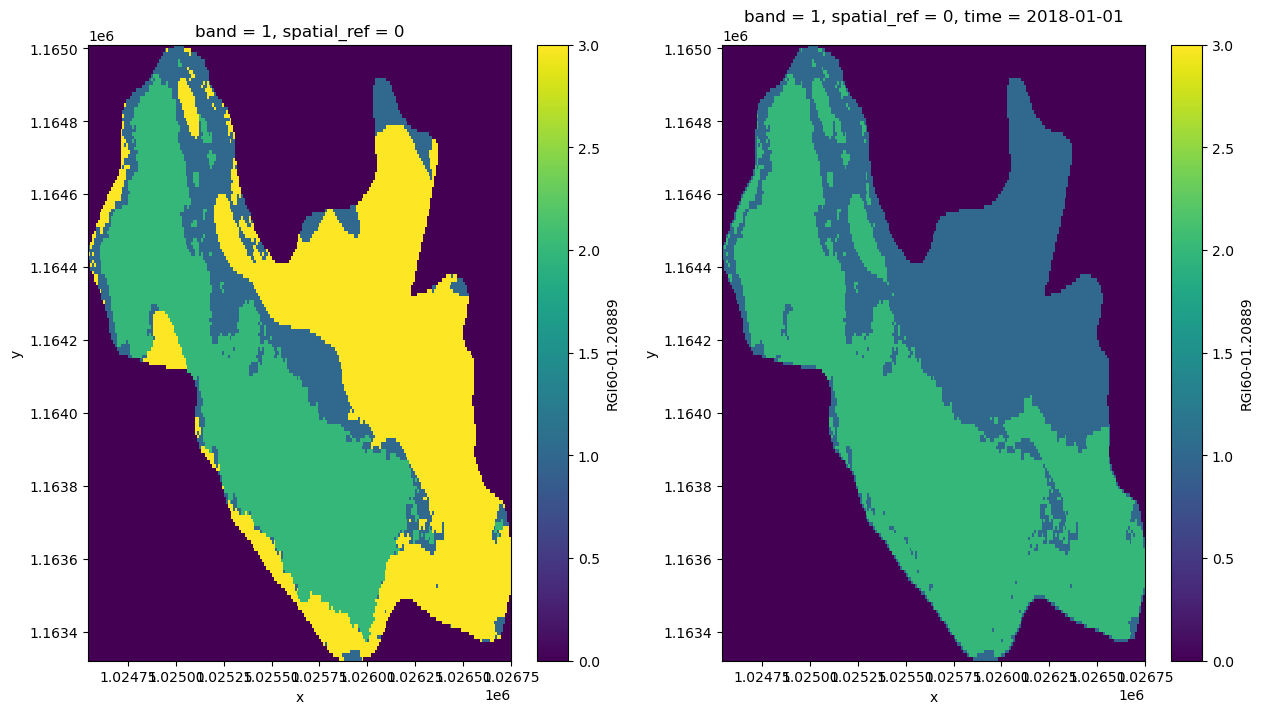

In [51]:

fig,axs=plt.subplots(1,2,figsize=(15,8))
snow.plot(ax=axs[0], vmin=0,vmax=3)
snow_infill.plot(ax=axs[1], vmin=0,vmax=3)